In [ ]:
# Команда pip install kaggle використовується для
#встановлення клієнта Kaggle API для підключення до бази даних Kaggle
!pip install kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"oksanayevtushenko","key":"690fa0a9e2098b36328476e6b3f3a5ca"}'}

In [ ]:
# Створення папки .kaggle і переміщення туди файлу
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/

# Зміна прав доступу до файлу
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d awsaf49/brats20-dataset-training-validation

Dataset URL: https://www.kaggle.com/datasets/awsaf49/brats20-dataset-training-validation
License(s): CC0-1.0
 99% 4.12G/4.16G [00:13<00:00, 387MB/s]
100% 4.16G/4.16G [00:13<00:00, 331MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile("brats20-dataset-training-validation.zip", "r") as zip_ref:
    zip_ref.extractall("/content/brats20-dataset-training-validation")

In [ ]:
import os
import nibabel as nib
from glob import glob
from tqdm import tqdm

# Директорії з .nii файлами
directories = [
    "/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData",
    "/content/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData"
]

# Проходимо по кожній директорії
for base_dir in directories:
    nii_files = sorted(glob(os.path.join(base_dir, "*", "*.nii")))

    print(f"🔄 Конвертація у: {base_dir}")
    for nii_path in tqdm(nii_files):
        # Завантаження .nii
        img = nib.load(nii_path)

        # Побудова шляху для збереження .nii.gz
        nii_gz_path = nii_path + ".gz"

        # Збереження у форматі .nii.gz
        nib.save(img, nii_gz_path)

        # (Необов’язково) Видалити старий .nii
        os.remove(nii_path)

print("✅ Усі файли .nii успішно конвертовані у .nii.gz")

🔄 Конвертація у: /content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData


100%|██████████| 1845/1845 [04:14<00:00,  7.26it/s]


🔄 Конвертація у: /content/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData


100%|██████████| 500/500 [01:24<00:00,  5.89it/s]

✅ Усі файли .nii успішно конвертовані у .nii.gz


In [ ]:
!pip install torchinfo

In [ ]:
import os
import random
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchinfo import summary
from torchsummary import summary
from torch.utils.data import DataLoader, Dataset
from torch.cuda.amp import GradScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import nibabel as nib
import warnings
warnings.filterwarnings('ignore')

In [ ]:
train_dir = "/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
val_dir = "/content/brats20-dataset-training-validation/BraTS2020_ValidationData/MICCAI_BraTS2020_ValidationData"

Випадково обраний кейс: BraTS20_Training_294


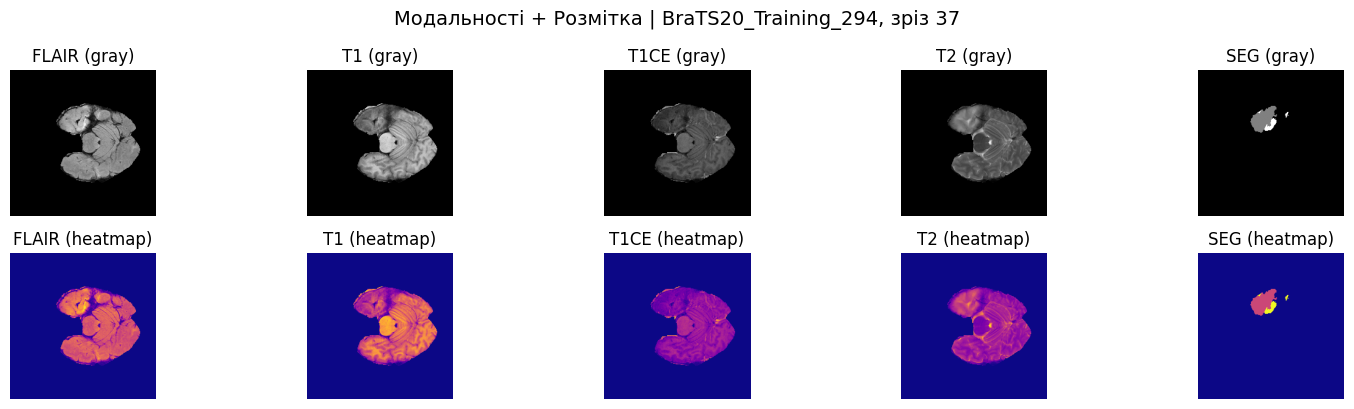

In [ ]:
# === Шлях до даних
data_dir = "/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

# === Отримати список доступних кейсів
all_cases = sorted([d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))])
case_id = random.choice(all_cases)
print("Випадково обраний кейс:", case_id)

case_path = os.path.join(data_dir, case_id)
modalities = ["flair", "t1", "t1ce", "t2"]
images = []

# === Завантаження модальностей
for mod in modalities:
    img_path = os.path.join(case_path, f"{case_id}_{mod}.nii.gz")
    img = nib.load(img_path).get_fdata()
    images.append(img)

# === Завантаження сегментації
seg_path = os.path.join(case_path, f"{case_id}_seg.nii.gz")
seg = nib.load(seg_path).get_fdata()

# === Вибрати випадковий slice (по осі Z)
max_slice = images[0].shape[2]
slice_id = random.randint(0, max_slice - 1)

# === Візуалізація
plt.figure(figsize=(15, 6))
for i in range(4):
    plt.subplot(3, 5, i + 1)
    plt.imshow(images[i][:, :, slice_id], cmap="gray")
    plt.title(f"{modalities[i].upper()} (gray)")
    plt.axis("off")

plt.subplot(3, 5, 5)
plt.imshow(seg[:, :, slice_id], cmap="gray")
plt.title("SEG (gray)")
plt.axis("off")

for i in range(4):
    plt.subplot(3, 5, i + 6)
    plt.imshow(images[i][:, :, slice_id], cmap="plasma")
    plt.title(f"{modalities[i].upper()} (heatmap)")
    plt.axis("off")

plt.subplot(3, 5, 10)
plt.imshow(seg[:, :, slice_id], cmap="plasma")
plt.title("SEG (heatmap)")
plt.axis("off")

plt.suptitle(f"Модальності + Розмітка | {case_id}, зріз {slice_id}", fontsize=14)
plt.tight_layout()
plt.show()


In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    num_gpus = torch.cuda.device_count()
    torch.cuda.empty_cache()  # Clear GPU cache before starting
    print(f"Using {num_gpus} GPUs for training." if num_gpus > 1 else
          f"Using {torch.cuda.get_device_name(0)} for training.")
else:
    print("Using CPU for training.")

Using NVIDIA A100-SXM4-40GB for training.


# **######################################################**

In [ ]:
# === Налаштування ===
data_dir = "/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"
all_patients = sorted([p for p in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, p))])

# === Розділення
random.seed(42)
random.shuffle(all_patients)

n_total = len(all_patients)
n_train = int(0.7 * n_total)
n_val   = int(0.15 * n_total)
n_test  = n_total - n_train - n_val

train_patients = all_patients[:n_train]
val_patients   = all_patients[n_train:n_train+n_val]
test_patients  = all_patients[n_train+n_val:]

# === Збереження списків
with open("train.txt", "w") as f:
    f.write("\n".join(train_patients))

with open("val.txt", "w") as f:
    f.write("\n".join(val_patients))

with open("test.txt", "w") as f:
    f.write("\n".join(test_patients))

print(f"✅ Записано: {len(train_patients)} train, {len(val_patients)} val, {len(test_patients)} test.")


✅ Записано: 258 train, 55 val, 56 test.


In [ ]:
# === 2. Датасет ===
class BraTSDataset(Dataset):
    def __init__(self, patient_list, data_dir, slice_range=(60, 100)):
        self.data_dir = data_dir
        self.patients = patient_list
        self.modalities = ["flair", "t1", "t1ce", "t2"]
        self.slice_range = slice_range

    def load_nifti(self, path):
        return np.array(nib.load(path).get_fdata(), dtype=np.float32)

    def __getitem__(self, idx):
        pid = self.patients[idx]
        p_path = os.path.join(self.data_dir, pid)
        imgs = []
        for mod in self.modalities:
            img = self.load_nifti(os.path.join(p_path, f"{pid}_{mod}.nii.gz"))
            img = img[:, :, self.slice_range[0]:self.slice_range[1]]
            img = (img - np.mean(img)) / (np.std(img) + 1e-6)
            imgs.append(np.nan_to_num(img))
        imgs = torch.tensor(np.stack(imgs), dtype=torch.float32)
        seg = self.load_nifti(os.path.join(p_path, f"{pid}_seg.nii.gz"))
        seg = seg[:, :, self.slice_range[0]:self.slice_range[1]]
        seg[seg == 4] = 3
        mask = torch.tensor(seg.astype(np.uint8), dtype=torch.long)
        return imgs, mask

    def __len__(self): return len(self.patients)

def read_patients(filename):
    with open(filename, "r") as f:
        return f.read().splitlines()

In [ ]:
train_loader = DataLoader(
    BraTSDataset(read_patients("train.txt"), data_dir),
    batch_size=1, shuffle=True
)

val_loader = DataLoader(
    BraTSDataset(read_patients("val.txt"), data_dir),
    batch_size=1, shuffle=False
)

test_loader = DataLoader(
    BraTSDataset(read_patients("test.txt"), data_dir),
    batch_size=1, shuffle=False
)


In [ ]:
# === Функція читання списків пацієнтів ===
def read_patients(filename):
    with open(filename, "r") as f:
        return f.read().splitlines()

# === Шляхи ===
data_dir = "/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

# === Зчитування пацієнтів з файлів ===
train_patients = read_patients("train.txt")
val_patients   = read_patients("val.txt")
test_patients  = read_patients("test.txt")

# === Створення наборів даних зі зменшеним обсягом (оптимізація памʼяті) ===
train_dataset = BraTSDataset(train_patients, data_dir, slice_range=(60, 100))
val_dataset   = BraTSDataset(val_patients, data_dir, slice_range=(60, 100))
test_dataset  = BraTSDataset(test_patients, data_dir,slice_range=(60, 100))

# === DataLoader-и ===
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

# === Перевірка форми одного зразка ===
sample_img, sample_mask = next(iter(train_loader))
print(f"Train image shape: {sample_img.shape}")
print(f"Train segmentation shape: {sample_mask.shape}")

sample_img, sample_mask = next(iter(val_loader))
print(f"Validation image shape: {sample_img.shape}")
print(f"Validation segmentation shape: {sample_mask.shape}")

sample_img, sample_mask = next(iter(test_loader))
print(f"Test image shape: {sample_img.shape}")


Train image shape: torch.Size([1, 4, 240, 240, 40])
Train segmentation shape: torch.Size([1, 240, 240, 40])
Validation image shape: torch.Size([1, 4, 240, 240, 40])
Validation segmentation shape: torch.Size([1, 240, 240, 40])
Test image shape: torch.Size([1, 4, 240, 240, 40])


In [ ]:
# === 4. Модель 3D U-Net ===
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)

        self.residual = nn.Conv3d(in_channels, out_channels, kernel_size=1) \
            if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        identity = self.residual(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return self.relu(out + identity)
class Improved3DUNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=4, base_filters=32):
        super().__init__()
        self.enc1 = ResidualBlock(in_channels, base_filters)
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = ResidualBlock(base_filters, base_filters * 2)
        self.pool2 = nn.MaxPool3d(2)

        self.bottleneck = ResidualBlock(base_filters * 2, base_filters * 4)

        self.up2 = nn.ConvTranspose3d(base_filters * 4, base_filters * 2, kernel_size=2, stride=2)
        self.dec2 = ResidualBlock(base_filters * 4, base_filters * 2)
        self.up1 = nn.ConvTranspose3d(base_filters * 2, base_filters, kernel_size=2, stride=2)
        self.dec1 = ResidualBlock(base_filters * 2, base_filters)

        self.out_conv = nn.Conv3d(base_filters, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.dec2(torch.cat([self.up2(b), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.out_conv(d1)

# === Ініціалізація моделі ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Improved3DUNet().to(device)

# === Вивід моделі (model.summary) ===
summary(model, input_size=(4, 128, 128, 64))

# === Збереження моделі ===
torch.save(model.state_dict(), "improved3dunet.pth")
print("Модель збережено як 'improved3dunet.pth'")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1     [-1, 32, 128, 128, 64]             160
            Conv3d-2     [-1, 32, 128, 128, 64]           3,488
       BatchNorm3d-3     [-1, 32, 128, 128, 64]              64
              ReLU-4     [-1, 32, 128, 128, 64]               0
            Conv3d-5     [-1, 32, 128, 128, 64]          27,680
       BatchNorm3d-6     [-1, 32, 128, 128, 64]              64
              ReLU-7     [-1, 32, 128, 128, 64]               0
     ResidualBlock-8     [-1, 32, 128, 128, 64]               0
         MaxPool3d-9       [-1, 32, 64, 64, 32]               0
           Conv3d-10       [-1, 64, 64, 64, 32]           2,112
           Conv3d-11       [-1, 64, 64, 64, 32]          55,360
      BatchNorm3d-12       [-1, 64, 64, 64, 32]             128
             ReLU-13       [-1, 64, 64, 64, 32]               0
           Conv3d-14       [-1, 64, 64,

In [ ]:
import torch
import torch.nn as nn
from torchinfo import summary

# === 1. Модель 3D U-Net з резідуальними блоками ===
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm3d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm3d(out_channels)

        self.residual = nn.Conv3d(in_channels, out_channels, kernel_size=1) \
            if in_channels != out_channels else nn.Identity()

    def forward(self, x):
        identity = self.residual(x)
        out = self.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        return self.relu(out + identity)

class Improved3DUNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=4, base_filters=32):
        super().__init__()
        self.enc1 = ResidualBlock(in_channels, base_filters)
        self.pool1 = nn.MaxPool3d(2)
        self.enc2 = ResidualBlock(base_filters, base_filters * 2)
        self.pool2 = nn.MaxPool3d(2)

        self.bottleneck = ResidualBlock(base_filters * 2, base_filters * 4)

        self.up2 = nn.ConvTranspose3d(base_filters * 4, base_filters * 2, kernel_size=2, stride=2)
        self.dec2 = ResidualBlock(base_filters * 4, base_filters * 2)
        self.up1 = nn.ConvTranspose3d(base_filters * 2, base_filters, kernel_size=2, stride=2)
        self.dec1 = ResidualBlock(base_filters * 2, base_filters)

        self.out_conv = nn.Conv3d(base_filters, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        b = self.bottleneck(self.pool2(e2))
        d2 = self.dec2(torch.cat([self.up2(b), e2], dim=1))
        d1 = self.dec1(torch.cat([self.up1(d2), e1], dim=1))
        return self.out_conv(d1)

# === 2. Завантаження моделі ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Improved3DUNet().to(device)

# === 3. Завантаження збережених ваг ===
model.load_state_dict(torch.load("improved3dunet.pth", map_location=device))
model.eval()

# === 4. Вивід архітектури моделі ===
summary(model, input_size=(1, 4, 128, 128, 64))  # [B, C, H, W, D]


Layer (type:depth-idx)                   Output Shape              Param #
Improved3DUNet                           [1, 4, 128, 128, 64]      --
├─ResidualBlock: 1-1                     [1, 32, 128, 128, 64]     --
│    └─Conv3d: 2-1                       [1, 32, 128, 128, 64]     160
│    └─Conv3d: 2-2                       [1, 32, 128, 128, 64]     3,488
│    └─BatchNorm3d: 2-3                  [1, 32, 128, 128, 64]     64
│    └─ReLU: 2-4                         [1, 32, 128, 128, 64]     --
│    └─Conv3d: 2-5                       [1, 32, 128, 128, 64]     27,680
│    └─BatchNorm3d: 2-6                  [1, 32, 128, 128, 64]     64
│    └─ReLU: 2-7                         [1, 32, 128, 128, 64]     --
├─MaxPool3d: 1-2                         [1, 32, 64, 64, 32]       --
├─ResidualBlock: 1-3                     [1, 64, 64, 64, 32]       --
│    └─Conv3d: 2-8                       [1, 64, 64, 64, 32]       2,112
│    └─Conv3d: 2-9                       [1, 64, 64, 64, 32]       55,360


In [ ]:
!pip install onnx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.6/17.6 MB 117.9 MB/s eta 0:00:00


In [ ]:
import torch

# === Створюємо модель і завантажуємо ваги ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Improved3DUNet().to(device)
model.load_state_dict(torch.load("improved3dunet.pth", map_location=device))
model.eval()

# === Створюємо фейковий вхід (dummy input) ===
dummy_input = torch.randn(1, 4, 128, 128, 64).to(device)  # [B, C, H, W, D]

# === Експортуємо в ONNX ===
torch.onnx.export(
    model,
    dummy_input,
    "improved3dunet.onnx",
    export_params=True,
    opset_version=11,
    do_constant_folding=True,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={
        'input': {0: 'batch_size'},
        'output': {0: 'batch_size'}
    }
)

print("✅ Модель збережено як 'improved3dunet.onnx'")


✅ Модель збережено як 'improved3dunet.onnx'


In [ ]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        # y_pred: model output logits [batch_size, 4, H, W, D], Float
        # y_true: mask [batch_size, H, W, D], Long

        #num_classes = y_pred.shape[1]
        y_pred = F.softmax(y_pred, dim=1)
        y_true_one_hot = F.one_hot(y_true, num_classes=y_pred.shape[1]).permute(0, 4, 1, 2, 3).float()
        y_pred = y_pred.view(y_pred.size(0), y_pred.size(1), -1)
        y_true_one_hot = y_true_one_hot.view(y_true_one_hot.size(0), y_true_one_hot.size(1), -1)
        intersection = (y_pred * y_true_one_hot).sum(dim=2)
        dice = (2. * intersection + self.smooth) / (y_pred.sum(dim=2) + y_true_one_hot.sum(dim=2) + self.smooth)
        return 1 - dice.mean()

class CombinedLoss(nn.Module):
    def __init__(self, weight_dice=0.7, weight_ce=0.3):
        """
        weight_dice: вага Dice втрати
        weight_ce: вага CrossEntropy втрати
        class_weights: необов'язково — Tensor розміром [num_classes] з вагами класів для CE
        """
        super().__init__()
        self.weight_dice = weight_dice
        self.weight_ce = weight_ce
        self.ce_loss = nn.CrossEntropyLoss()
        self.dice_loss = DiceLoss()

    def forward(self, inputs, targets):
        ce = self.ce_loss(inputs, targets)
        dice = self.dice_loss(inputs, targets)
        return self.weight_ce * ce + self.weight_dice * dice

In [ ]:
# Initialize model with improved architecture
model = Improved3DUNet(in_channels=4, out_channels=4, base_filters=16).to(device)
model = model.to(device)

# Use mixed precision for memory efficiency
use_amp = True
scaler = GradScaler(enabled=use_amp)

# Use combined loss for better segmentation results
criterion = CombinedLoss(weight_dice=0.7, weight_ce=0.3)

# Cosine annealing learning rate for better convergence
optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=30, eta_min=1e-6)

# Updated Dice coefficient for evaluation
def dice_coefficient(y_pred, y_true, smooth=1e-6):
    # Обчислює середній Dice по всіх класах і батчу
    # y_pred - логіти [B, C, H, W, D]
    # y_true - маска [B, H, W, D]
    num_classes = y_pred.shape[1]
    y_pred_soft = F.softmax(y_pred.float(), dim=1)  # Convert logits to probabilities
    y_true_one_hot = F.one_hot(y_true, num_classes=num_classes).permute(0, 4, 1, 2, 3).float()

    y_pred_flat = y_pred_soft.view(y_pred_soft.size(0), num_classes, -1)
    y_true_flat = y_true_one_hot.view(y_true_one_hot.size(0), num_classes, -1)

    intersection = (y_pred_flat * y_true_flat).sum(dim=2)
    union = y_pred_flat.sum(dim=2) + y_true_flat.sum(dim=2)

    dice = (2. * intersection + smooth) / (union + smooth)
    return dice.mean().item()

In [ ]:
def iou_and_accuracy(y_pred, y_true, num_classes=4, ignore_background=True, smooth=1e-6):
  # Обчислює середні значення IoU та точності (Accuracy) по кожному класу (воксельно)
  # y_pred: логіти з моделі [B, C, H, W, D]
  # y_true: справжня розмітка [B, H, W, D]
  # Отримуємо прогнозовані класи з логітів
  y_pred_labels = torch.argmax(y_pred, dim=1) # [B, H, W, D]
  mean_ious, mean_accs = [], []
  class_range = range(1, num_classes) if ignore_background else range(num_classes)

  # Ітеруємося по класах, починаючи з 1, якщо ignore_clas_0 = True
  for cls in class_range:
    # Створюємо маски для прогнозованих та фактичних значень для поточного класу
    pred_mask = (y_pred_labels == cls)
    true_mask = (y_true == cls)
    # Обчислюємо Intersection та Unoin
    intersection = (pred_mask & true_mask).sum().float()
    union = (pred_mask | true_mask).sum().float()
    total_voxels = torch.numel(true_mask)
    correct_voxels = (pred_mask == true_mask).sum().float()

    iou = (intersection + smooth) / (union + smooth)
    acc = correct_voxels / total_voxels
    # Додаємо IoU та Accuracy в списки, якщо Union > 0
    if union > 0:
      mean_ious.append(iou)
      mean_accs.append(acc)
  # Обчислюємо середні значення IoU та Accuracy, якщо є хоч якісь значення в списках
  avg_iou = torch.mean(torch.stack(mean_ious)) if mean_ious else torch.tensor(0.0)
  avg_acc = torch.mean(torch.stack(mean_accs)) if mean_accs else torch.tensor(0.0)
  return avg_iou.item(), avg_acc.item()

In [ ]:
# === 1. Навчання на одну епоху ===
def train_one_epoch(model, dataloader, optimizer, criterion, device, scaler=None, use_amp=True):
    model.train()
    total_loss, total_dice, total_iou, total_acc = 0.0, 0.0, 0.0, 0.0

    for i, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()

        with torch.cuda.amp.autocast(enabled=use_amp):
          out = model(x)
          loss = criterion(out, y)

        if scaler:
          scaler.scale(loss).backward()
          scaler.unscale_(optimizer)
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
          scaler.step(optimizer)
          scaler.update()
        else:
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()

        # Метрики
        total_loss += loss.item()
        total_dice += dice_coefficient(out, y)
        iou, acc = iou_and_accuracy(out, y)
        total_iou += iou
        total_acc += acc

        torch.cuda.empty_cache()

    n = len(dataloader)
    return total_loss / n, total_dice / n, total_iou / n, total_acc / n

# === 2. Валідація на одну епоху ===
def validate_one_epoch(model, dataloader, criterion, device, use_amp=True):
    model.eval()
    total_loss, total_dice, total_iou, total_acc = 0.0, 0.0, 0.0, 0.0

    with torch.no_grad():
        for x, y in dataloader:
            x, y = x.to(device), y.to(device)
            with torch.cuda.amp.autocast(enabled=use_amp):
                out = model(x)
                loss = criterion(out, y)

            total_loss += loss.item()
            total_dice += dice_coefficient(out, y)
            iou, acc = iou_and_accuracy(out, y)
            total_iou += iou
            total_acc += acc

            torch.cuda.empty_cache()

    n = len(dataloader)
    return total_loss / n, total_dice / n, total_iou / n, total_acc / n


# === 3. Клас ранньої зупинки ===
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = float('inf')
        self.early_stop = False

    def step(self, val_loss):
        if val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True



Epoch [1/100]
Train | Loss: 0.5111 | Dice: 0.3943 | Iou: 0.2489 | Acc: 0.9888
Val | Loss: 0.3312 | Dice: 0.5533 | Iou: 0.3232 | Acc: 0.9919 | LR: 0.000200

 Найкращу модель збережено (Dice: 0.5533)

Epoch [2/100]
Train | Loss: 0.2875 | Dice: 0.6144 | Iou: 0.4012 | Acc: 0.9940
Val | Loss: 0.2868 | Dice: 0.6176 | Iou: 0.3984 | Acc: 0.9930 | LR: 0.000199

 Найкращу модель збережено (Dice: 0.6176)

Epoch [3/100]
Train | Loss: 0.2664 | Dice: 0.6431 | Iou: 0.4312 | Acc: 0.9946
Val | Loss: 0.2847 | Dice: 0.6228 | Iou: 0.4128 | Acc: 0.9938 | LR: 0.000198

 Найкращу модель збережено (Dice: 0.6228)

Epoch [4/100]
Train | Loss: 0.2486 | Dice: 0.6671 | Iou: 0.4617 | Acc: 0.9949
Val | Loss: 0.2716 | Dice: 0.6422 | Iou: 0.4342 | Acc: 0.9933 | LR: 0.000195

 Найкращу модель збережено (Dice: 0.6422)

Epoch [5/100]
Train | Loss: 0.2345 | Dice: 0.6872 | Iou: 0.4920 | Acc: 0.9952
Val | Loss: 0.2553 | Dice: 0.6663 | Iou: 0.4596 | Acc: 0.9941 | LR: 0.000191

 Найкращу модель збережено (Dice: 0.6663)

Epoc

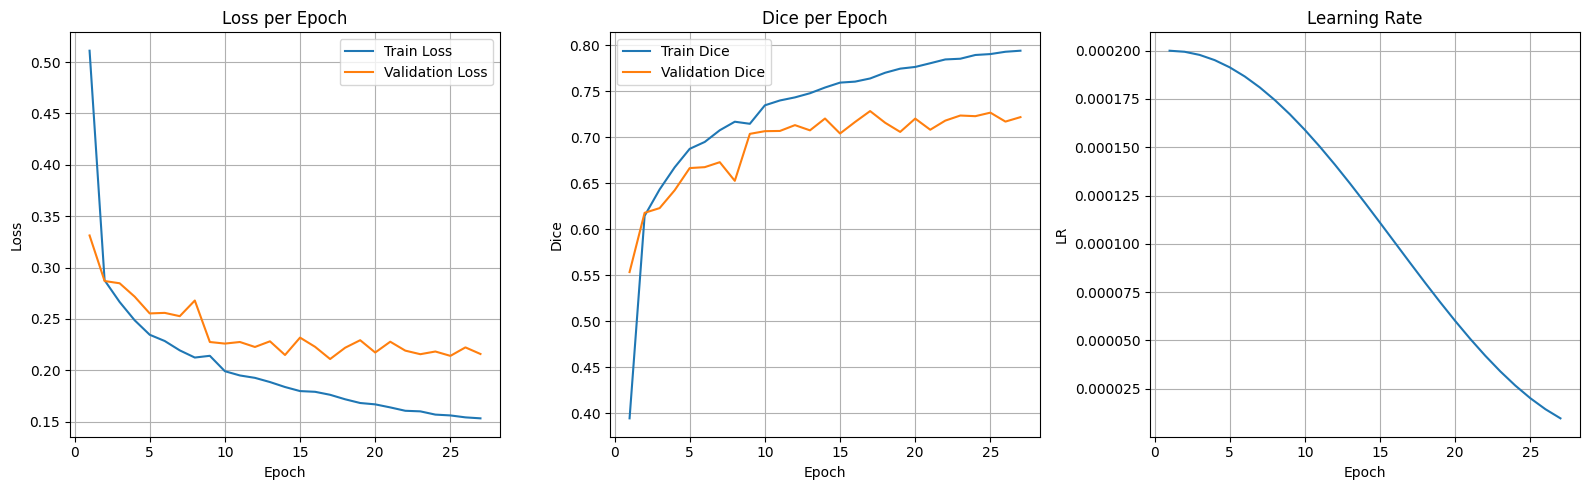


 Тренування завершено! Найкращий Dice на валідації: 0.7282


In [ ]:
# === Параметри тренування ===
num_epochs = 100
best_val_dice = 0.0
early_stopping = EarlyStopping(patience=10)

# === Логи для метрик ===
train_losses, val_losses = [], []
train_dice_scores, val_dice_scores = [], []
train_accuracies, val_accuracies = [], []
train_ious, val_ious = [], []
learning_rates = []


try:
    for epoch in range(num_epochs):
        print(f"\nEpoch [{epoch+1}/{num_epochs}]")

        # === Тренування ===
        train_loss, train_dice, train_iou, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device, scaler)

        # === Валідація ===
        val_loss, val_dice, val_iou, val_acc = validate_one_epoch(model, val_loader, criterion, device)

        # === Збір метрик ===
        train_losses.append(train_loss)
        train_dice_scores.append(train_dice)
        train_accuracies.append(train_acc)
        train_ious.append(train_iou)

        val_losses.append(val_loss)
        val_dice_scores.append(val_dice)
        val_accuracies.append(val_acc)
        val_ious.append(val_iou)

        # === Навчальна швидкість ===
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)
        scheduler.step()

        # === Вивід метрик ===
        print(f"Train | Loss: {train_loss:.4f} | Dice: {train_dice:.4f} | Iou: {train_iou:.4f} | Acc: {train_acc:.4f}")
        print(f"Val | Loss: {val_loss:.4f} | Dice: {val_dice:.4f} | Iou: {val_iou:.4f} | Acc: {val_acc:.4f} | LR: {current_lr:.6f}")

        # === Збереження найкращої моделі ===
        if val_dice > best_val_dice:
          best_val_dice = val_dice
          torch.save(model.state_dict(), 'best_brats_model_dice.pth')
          print(f"\n Найкращу модель збережено (Dice: {best_val_dice:.4f})")

        # === Перевірка на ранню зупинку ===
        early_stopping.step(val_loss)
        if early_stopping.early_stop:
          print("\n Рання зупинка - тренування завершено.")
          break
        torch.cuda.empty_cache()


except Exception as e:
    print(f"\n Помилка під час тренування: {e}")
    torch.save(model.state_dict(), 'interrupted_model.pth')
    print("Модель збережена як 'interrupted_model.pth'")

# === Побудова графіків ===
epochs = range(1, len(train_losses) + 1)
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
plt.plot(epochs, train_dice_scores, label='Train Dice')
plt.plot(epochs, val_dice_scores, label='Validation Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice')
plt.title('Dice per Epoch')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
plt.plot(epochs, learning_rates)
plt.xlabel('Epoch')
plt.ylabel('LR')
plt.title('Learning Rate')
plt.grid(True)

plt.tight_layout()
plt.savefig('training_metrics_summary.png')
plt.show()

print(f"\n Тренування завершено! Найкращий Dice на валідації: {best_val_dice:.4f}")

Графік метрик збережено у 'training_metrics.png'


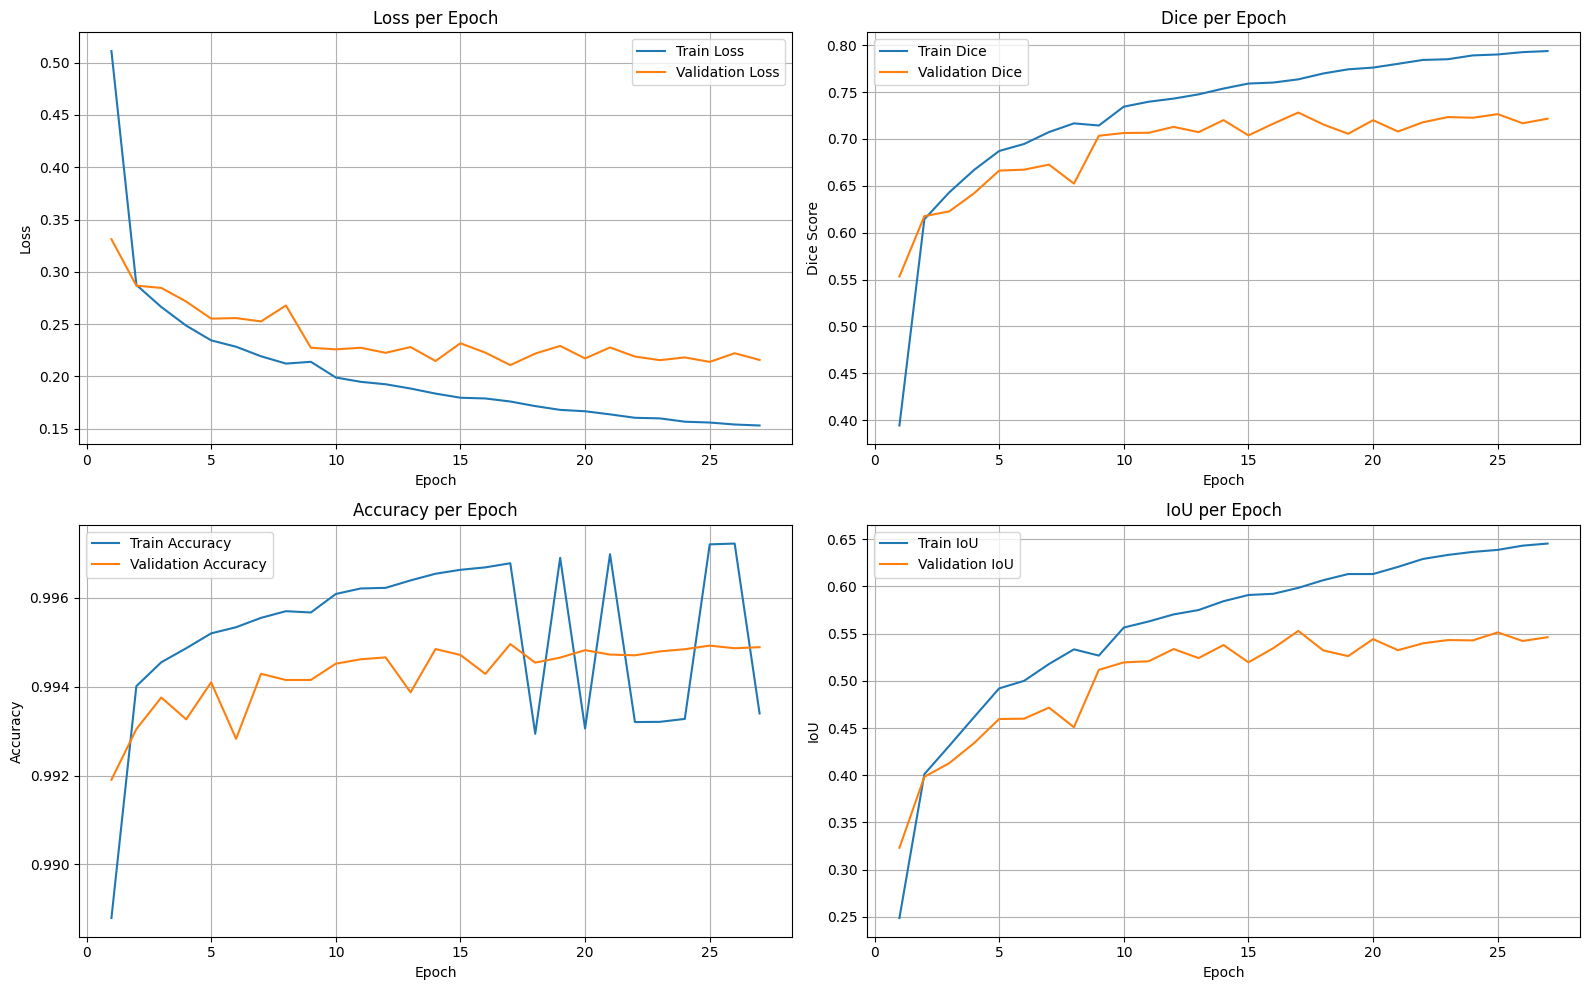

In [ ]:
# Plot metrics only if training completed
if len(train_losses) > 0:
  try:
    epochs = list(range(1, len(train_losses) +1))
    plt.figure(figsize=(16, 10))  # Збільшено висоту фігури

    # Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss per Epoch')
    plt.legend()
    plt.grid(True)

    # Dice
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_dice_scores, label='Train Dice')
    plt.plot(epochs, val_dice_scores, label='Validation Dice')
    plt.xlabel('Epoch')
    plt.ylabel('Dice Score')
    plt.title('Dice per Epoch')
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(2, 2, 3)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy per Epoch')
    plt.legend()
    plt.grid(True)

    # IoU
    plt.subplot(2, 2, 4)
    plt.plot(epochs, train_ious, label='Train IoU')
    plt.plot(epochs, val_ious, label='Validation IoU')
    plt.xlabel('Epoch')
    plt.ylabel('IoU')
    plt.title('IoU per Epoch')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.savefig('training_metrics.png')
    print("Графік метрик збережено у 'training_metrics.png'")
  except Exception as e:
    print(f"Помилка при створенні графіків: {e}")

Результати навчання - мають бути графіки Loss і метрики на тренувальний/валідаційний виборках

In [ ]:
def plot_training_results(train_losses, val_losses,
                          train_dice_scores, val_dice_scores,
                          train_accuracies, val_accuracies,
                          train_ious, val_ious,
                          save_path='training_metrics.png'):
    try:
        epochs = range(1, len(train_losses) + 1)
        plt.figure(figsize=(16, 10))

        # Loss
        plt.subplot(3, 2, 1)
        plt.plot(epochs, train_losses, label='Train Loss')
        plt.plot(epochs, val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss per Epoch')
        plt.legend()
        plt.grid(True)

        # Dice
        plt.subplot(3, 2, 2)
        plt.plot(epochs, train_dice_scores, label='Train Dice')
        plt.plot(epochs, val_dice_scores, label='Validation Dice')
        plt.xlabel('Epoch')
        plt.ylabel('Dice Score')
        plt.title('Dice per Epoch')
        plt.legend()
        plt.grid(True)

        # Accuracy
        plt.subplot(3, 2, 3)
        plt.plot(epochs, train_accuracies, label='Train Accuracy')
        plt.plot(epochs, val_accuracies, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.title('Accuracy per Epoch')
        plt.legend()
        plt.grid(True)

        # IoU
        plt.subplot(3, 2, 4)
        plt.plot(epochs, train_ious, label='Train IoU')
        plt.plot(epochs, val_ious, label='Validation IoU')
        plt.xlabel('Epoch')
        plt.ylabel('IoU')
        plt.title('IoU per Epoch')
        plt.legend()
        plt.grid(True)

        # Empty subplots for symmetry
        plt.subplot(3, 2, 5)
        plt.axis('off')
        plt.subplot(3, 2, 6)
        plt.axis('off')

        plt.tight_layout()
        plt.savefig(save_path)
        print(f"Графіки збережено у '{save_path}'")
        plt.show()
    except Exception as e:
        print(f"Помилка при створенні графіків: {e}")


Графіки збережено у 'training_metrics.png'


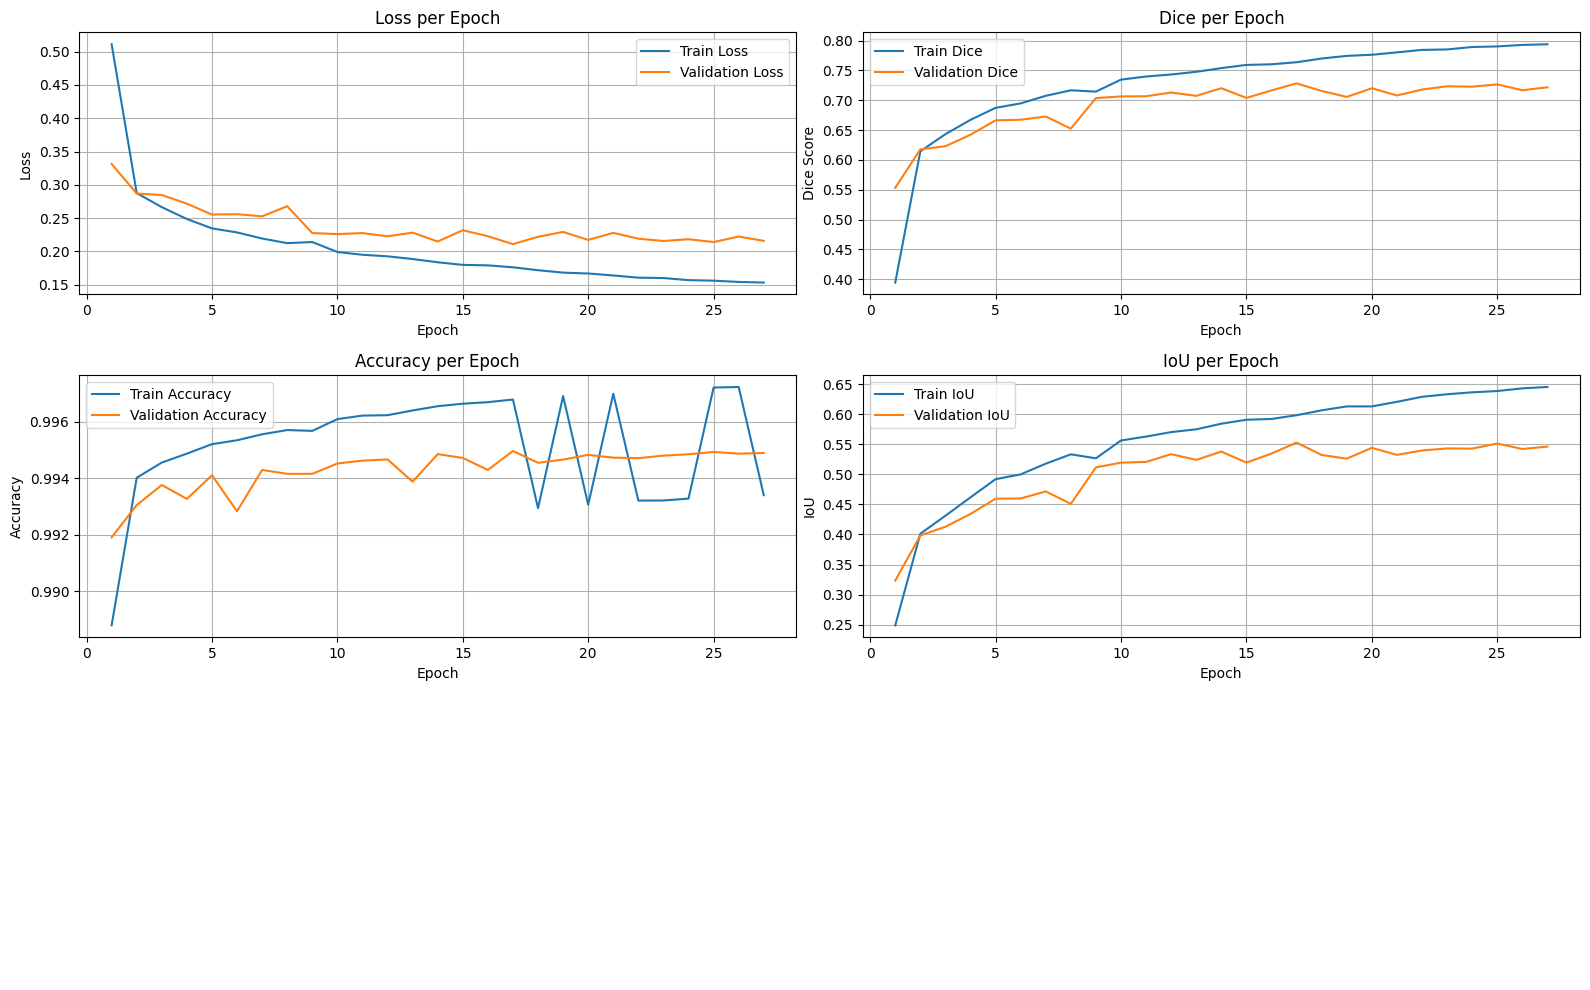

In [ ]:
plot_training_results(train_losses, val_losses, train_dice_scores, val_dice_scores, train_accuracies, val_accuracies, train_ious, val_ious)

In [ ]:
# === Завантаження найкращої моделі ===
model = Improved3DUNet(in_channels=4, out_channels=4, base_filters=16).to(device)  # або best_model.pth, якщо ви зберігали state_dict
model.load_state_dict(torch.load("best_brats_model_dice.pth"))
model.eval()

all_preds = []
all_targets = []

# === Обхід тестових даних ===
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)

        y_pred = model(x)
        preds = torch.argmax(y_pred, dim=1)

        all_preds.extend(preds.cpu().numpy().flatten())
        all_targets.extend(y.cpu().numpy().flatten())

# === Метрики по вокселях ===
class_names = ["Фон", "Некроз", "Набряк", "Активна пухлина"]

# === CLassification Report (по вокселях, для Precision/Recall/F1) ===
print("=== Classification Report ===")
print(classification_report(all_targets, all_preds, target_names=class_names, digits=4))

# === Confusion Matrix ===
print("=== Confusion Matrix (по вокселях)===")
cm = confusion_matrix(all_targets, all_preds, labels=[0, 1, 2, 3])
print(cm)

# === Функція Dice та IoU для кожного класу ===
def dice_iou_per_class(y_true, y_pred, class_id):
    y_true_bin = (np.array(y_true) == class_id).astype(np.uint8)
    y_pred_bin = (np.array(y_pred) == class_id).astype(np.uint8)

    intersection = np.sum(y_true_bin * y_pred_bin)
    union = np.sum(y_true_bin) + np.sum(y_pred_bin)

    iou_denom = np.sum(y_true_bin + y_pred_bin > 0)
    dice = (2. * intersection + 1e-6) / (union + 1e-6)
    iou = (intersection + 1e-6) / (iou_denom + 1e-6)
    return dice, iou


print("\n=== Метрики сегментації по кожному типу тканини ===")
print(f"{'Типи тканини':<20} {'Dice':<10} {'IoU':<10} {'Precision':<10} {'Recall':<10} {'F1-score':<10}")
for i, name in enumerate(class_names):
    dice, iou = dice_iou_per_class(all_targets, all_preds, i)

    y_true_bin = (np.array(all_targets) == i).astype(np.uint8)
    y_pred_bin = (np.array(all_preds) == i).astype(np.uint8)
    precision = precision_score(y_true_bin, y_pred_bin, zero_division=0)
    recall = recall_score(y_true_bin, y_pred_bin, zero_division=0)
    f1 = f1_score(y_true_bin, y_pred_bin, zero_division=0)
    print(f"{name:<20} {dice:<10.4f} {iou:<10.4f} {precision:10.4f} {recall:<10.4} {f1:<10.4f}")


=== Classification Report ===
                 precision    recall  f1-score   support

            Фон     0.9964    0.9965    0.9964 125594236
         Некроз     0.7162    0.4310    0.5382    901510
         Набряк     0.6785    0.7767    0.7243   1824123
Активна пухлина     0.7150    0.8041    0.7570    704131

       accuracy                         0.9884 129024000
      macro avg     0.7765    0.7521    0.7540 129024000
   weighted avg     0.9884    0.9884    0.9881 129024000

=== Confusion Matrix (по вокселях)===
[[125151454      8437    284629    149716]
 [   119965    388571    347953     45021]
 [   276550     99937   1416708     30928]
 [    53709     45614     38592    566216]]

=== Метрики сегментації по кожному типу тканини ===
Типи тканини         Dice       IoU        Precision  Recall     F1-score  
Фон                  0.9964     0.9929         0.9964 0.9965     0.9964    
Некроз               0.5382     0.3681         0.7162 0.431      0.5382    
Набряк             

In [ ]:
model = Improved3DUNet(in_channels=4, out_channels=4, base_filters=16).to(device)  # або best_model.pth, якщо ви зберігали state_dict
model.load_state_dict(torch.load("best_brats_model_dice.pth"))
model.eval()

# === Обхід тестових даних ===
all_preds = []
all_targets = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        preds = torch.argmax(y_pred, dim=1)
        all_preds.extend(preds.cpu().numpy().flatten())
        all_targets.extend(y.cpu().numpy().flatten())

# === Назви тканин ===
tissue_types = ["Фон", "Некроз", "Набряк", "Активна пухлина"]

# === Функція Dice та IoU ===
def dice_iou_per_class(y_true, y_pred, class_id):
    y_true_bin = (np.array(y_true) == class_id).astype(np.uint8)
    y_pred_bin = (np.array(y_pred) == class_id).astype(np.uint8)
    intersection = np.sum(y_true_bin * y_pred_bin)
    union = np.sum(y_true_bin) + np.sum(y_pred_bin)
    iou_denom = np.sum((y_true_bin + y_pred_bin) > 0)
    dice = (2. * intersection + 1e-6) / (union + 1e-6)
    iou = (intersection + 1e-6) / (iou_denom + 1e-6)
    return dice, iou

# === Збір метрик у DataFrame ===
results = []
for i, label in enumerate(tissue_types):
    dice, iou = dice_iou_per_class(all_targets, all_preds, i)

    y_true_bin = (np.array(all_targets) == i).astype(np.uint8)
    y_pred_bin = (np.array(all_preds) == i).astype(np.uint8)
    precision = precision_score(y_true_bin, y_pred_bin, zero_division=0)
    recall = recall_score(y_true_bin, y_pred_bin, zero_division=0)
    f1 = f1_score(y_true_bin, y_pred_bin, zero_division=0)

    results.append({
        "Тип тканини": label,
        "Dice": round(dice, 4),
        "IoU": round(iou, 4),
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "F1-score": round(f1, 4)
    })

df = pd.DataFrame(results)
df.to_csv("segmentation_report.csv", index=False, encoding='utf-8-sig')

# === Друк у консоль ===
print(df)


       Тип тканини    Dice     IoU  Precision  Recall  F1-score
0              Фон  0.9964  0.9929     0.9964  0.9965    0.9964
1           Некроз  0.5382  0.3681     0.7162  0.4310    0.5382
2           Набряк  0.7243  0.5678     0.6785  0.7767    0.7243
3  Активна пухлина  0.7570  0.6090     0.7150  0.8041    0.7570


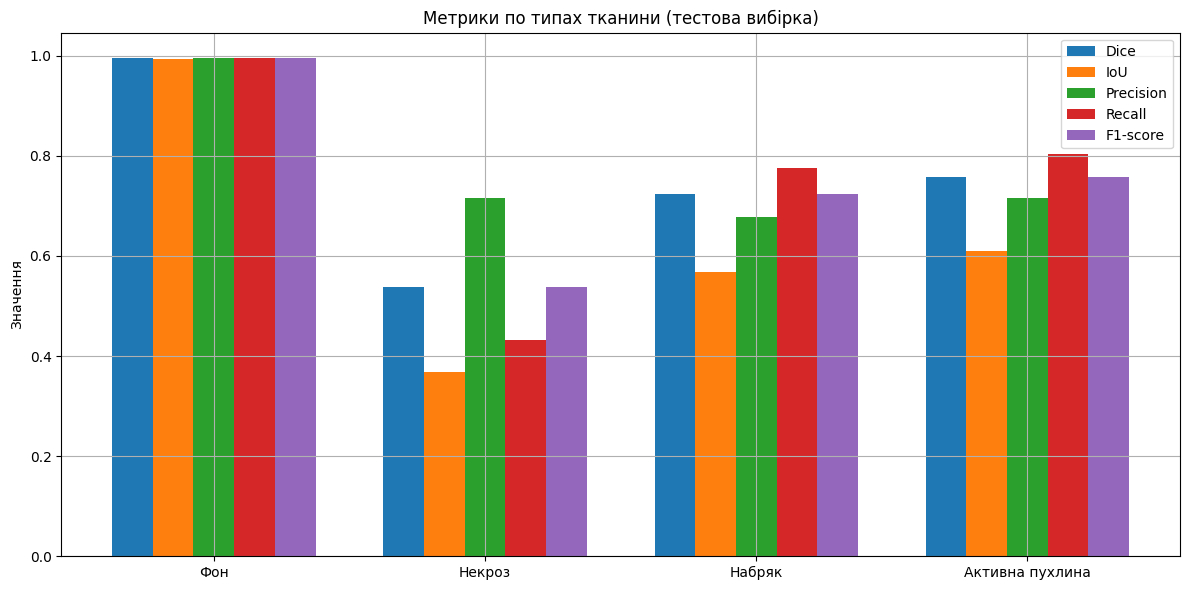

In [ ]:
# === Завантаження моделі ===
model = Improved3DUNet(in_channels=4, out_channels=4, base_filters=16).to(device)
model.load_state_dict(torch.load("best_brats_model_dice.pth"))
model.eval()

# === Збір предиктів ===
all_preds = []
all_targets = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        pred = torch.argmax(y_pred, dim=1)
        all_preds.extend(pred.cpu().numpy().flatten())
        all_targets.extend(y.cpu().numpy().flatten())

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)


class_names = ["Фон", "Некроз", "Набряк", "Активна пухлина"]

dice_scores = []
iou_scores = []
precision_scores = []
recall_scores = []
f1_scores = []

for class_id in range(4):
    y_true_bin = (all_targets == class_id).astype(np.uint8)
    y_pred_bin = (all_preds == class_id).astype(np.uint8)

    intersection = np.sum(y_true_bin * y_pred_bin)
    union = np.sum(y_true_bin) + np.sum(y_pred_bin)
    iou_denom = np.sum((y_true_bin + y_pred_bin) > 0)

    dice = (2 * intersection + 1e-6) / (union + 1e-6)
    iou = (intersection + 1e-6) / (iou_denom + 1e-6)

    prec = precision_score(y_true_bin, y_pred_bin, zero_division=0)
    rec = recall_score(y_true_bin, y_pred_bin, zero_division=0)
    f1 = f1_score(y_true_bin, y_pred_bin, zero_division=0)

    dice_scores.append(dice)
    iou_scores.append(iou)
    precision_scores.append(prec)
    recall_scores.append(rec)
    f1_scores.append(f1)

x = np.arange(len(class_names))
width = 0.15

plt.figure(figsize=(12, 6))
plt.bar(x - 2*width, dice_scores, width, label='Dice')
plt.bar(x - width, iou_scores, width, label='IoU')
plt.bar(x, precision_scores, width, label='Precision')
plt.bar(x + width, recall_scores, width, label='Recall')
plt.bar(x + 2*width, f1_scores, width, label='F1-score')

plt.xticks(x, class_names)
plt.ylabel("Значення")
plt.title("Метрики по типах тканини (тестова вибірка)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Таблиця метрик збережена у 'segmentation_metrics.csv'
Графік метрик збережено у 'segmentation_metrics_plot.png'


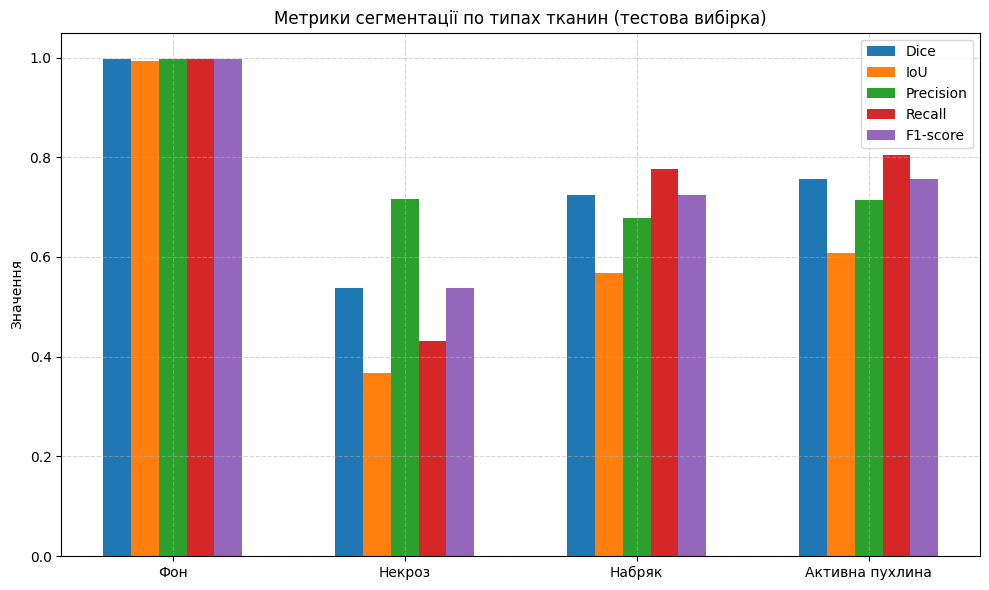

In [ ]:
# === Завантаження найкращої моделі ===
model = Improved3DUNet(in_channels=4, out_channels=4, base_filters=16).to(device)
model.load_state_dict(torch.load("best_brats_model_dice.pth"))
model.eval()

all_preds = []
all_targets = []

# === Обхід тестових даних ===
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_pred = model(x)
        preds = torch.argmax(y_pred, dim=1)
        all_preds.extend(preds.cpu().numpy().flatten())
        all_targets.extend(y.cpu().numpy().flatten())

# === Функція Dice та IoU ===
def dice_iou_per_class(y_true, y_pred, class_id):
    y_true_bin = (np.array(y_true) == class_id).astype(np.uint8)
    y_pred_bin = (np.array(y_pred) == class_id).astype(np.uint8)
    intersection = np.sum(y_true_bin * y_pred_bin)
    union = np.sum(y_true_bin) + np.sum(y_pred_bin)
    iou_denom = np.sum(y_true_bin + y_pred_bin > 0)
    dice = (2. * intersection + 1e-6) / (union + 1e-6)
    iou = (intersection + 1e-6) / (iou_denom + 1e-6)
    return dice, iou

# === Обчислення метрик по кожному класу ===
class_names = ["Фон", "Некроз", "Набряк", "Активна пухлина"]
metrics_data = []

for i, name in enumerate(class_names):
    dice, iou = dice_iou_per_class(all_targets, all_preds, i)
    y_true_bin = (np.array(all_targets) == i).astype(np.uint8)
    y_pred_bin = (np.array(all_preds) == i).astype(np.uint8)
    precision = precision_score(y_true_bin, y_pred_bin, zero_division=0)
    recall = recall_score(y_true_bin, y_pred_bin, zero_division=0)
    f1 = f1_score(y_true_bin, y_pred_bin, zero_division=0)
    metrics_data.append({
        "Тип тканини": name,
        "Dice": dice,
        "IoU": iou,
        "Precision": precision,
        "Recall": recall,
        "F1-score": f1
    })

# === Збереження в CSV ===
df_metrics = pd.DataFrame(metrics_data)
df_metrics.to_csv("segmentation_metrics.csv", index=False)
print("Таблиця метрик збережена у 'segmentation_metrics.csv'")

# === Побудова графіка ===
plt.figure(figsize=(10, 6))
bar_width = 0.12
x = np.arange(len(class_names))

for i, metric in enumerate(["Dice", "IoU", "Precision", "Recall", "F1-score"]):
    plt.bar(x + i * bar_width,
            [row[metric] for row in metrics_data],
            width=bar_width, label=metric)

plt.xticks(x + bar_width * 2, class_names)
plt.ylabel("Значення")
plt.title("Метрики сегментації по типах тканин (тестова вибірка)")
plt.ylim(0, 1.05)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("segmentation_metrics_plot.png")
print("Графік метрик збережено у 'segmentation_metrics_plot.png'")


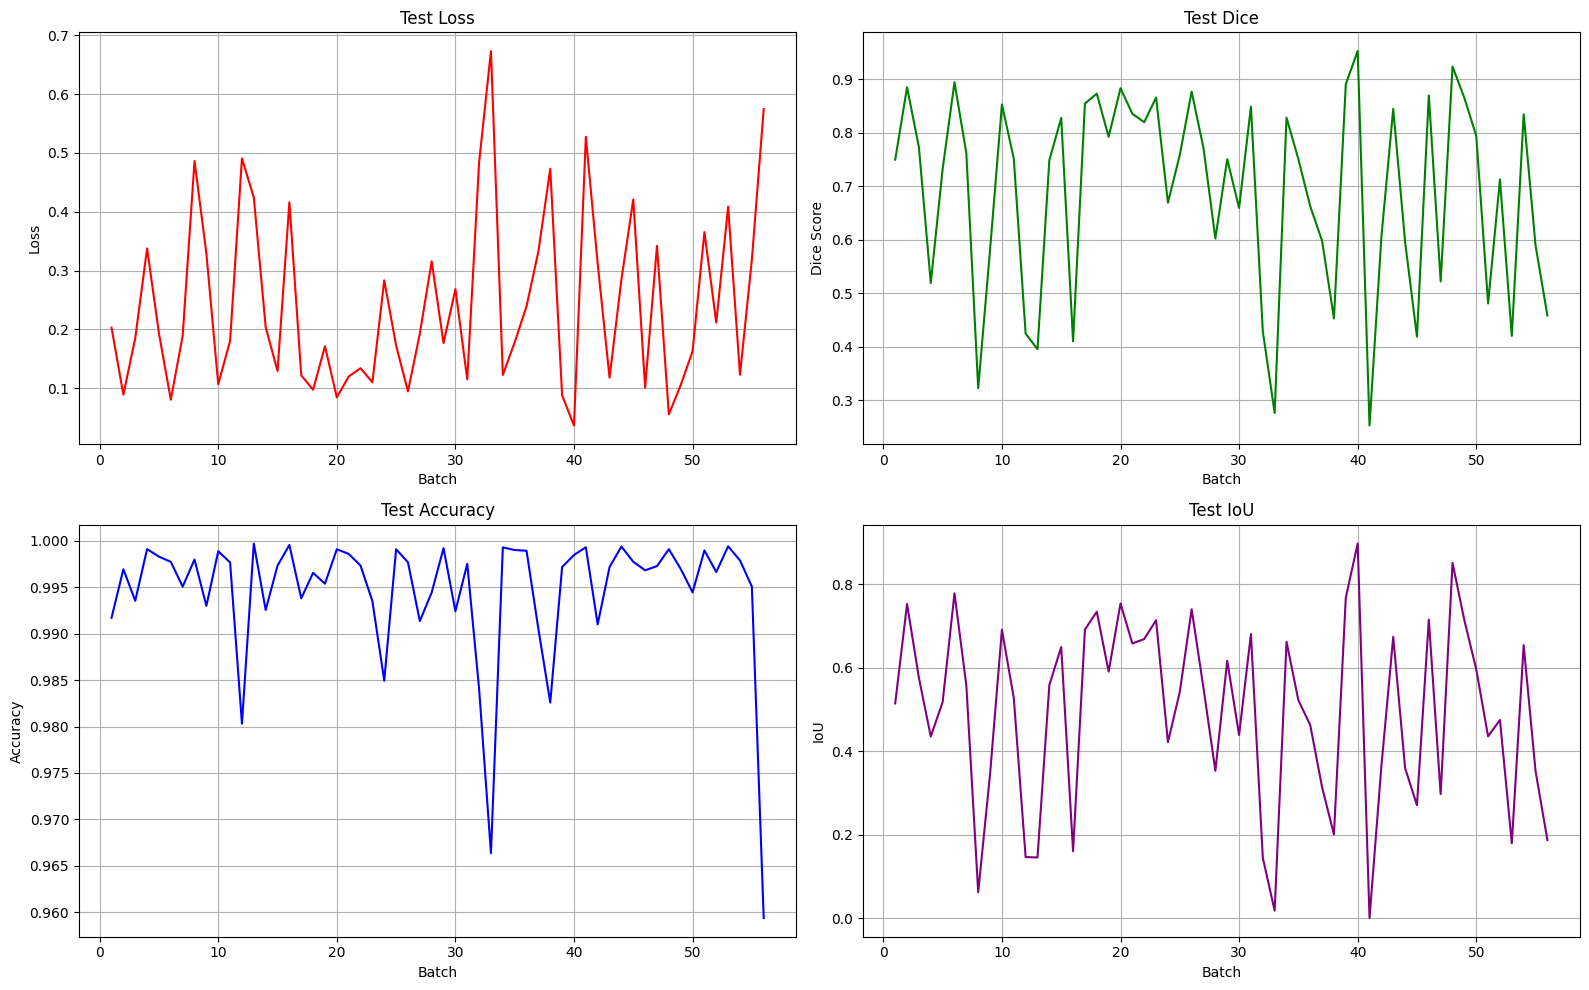

In [ ]:
# === Обчислення метрик на тестовій вибірці ===
model.eval()
test_losses = []
test_dices = []
test_accuracies = []
test_ious = []

with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        y_pred = model(x)

        loss = criterion(y_pred, y)
        test_losses.append(loss.item())

        dice = dice_coefficient(y_pred, y)
        iou, acc = iou_and_accuracy(y_pred, y)

        test_dices.append(dice)
        test_accuracies.append(acc)
        test_ious.append(iou)

# === Побудова графіків по тесту ===
epochs = list(range(1, len(test_losses) + 1))
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.plot(epochs, test_losses, label='Test Loss', color='red')
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Test Loss")
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(epochs, test_dices, label='Test Dice', color='green')
plt.xlabel("Batch")
plt.ylabel("Dice Score")
plt.title("Test Dice")
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(epochs, test_accuracies, label='Test Accuracy', color='blue')
plt.xlabel("Batch")
plt.ylabel("Accuracy")
plt.title("Test Accuracy")
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(epochs, test_ious, label='Test IoU', color='purple')
plt.xlabel("Batch")
plt.ylabel("IoU")
plt.title("Test IoU")
plt.grid(True)

plt.tight_layout()
plt.savefig("test_metrics_plot.png")
plt.show()


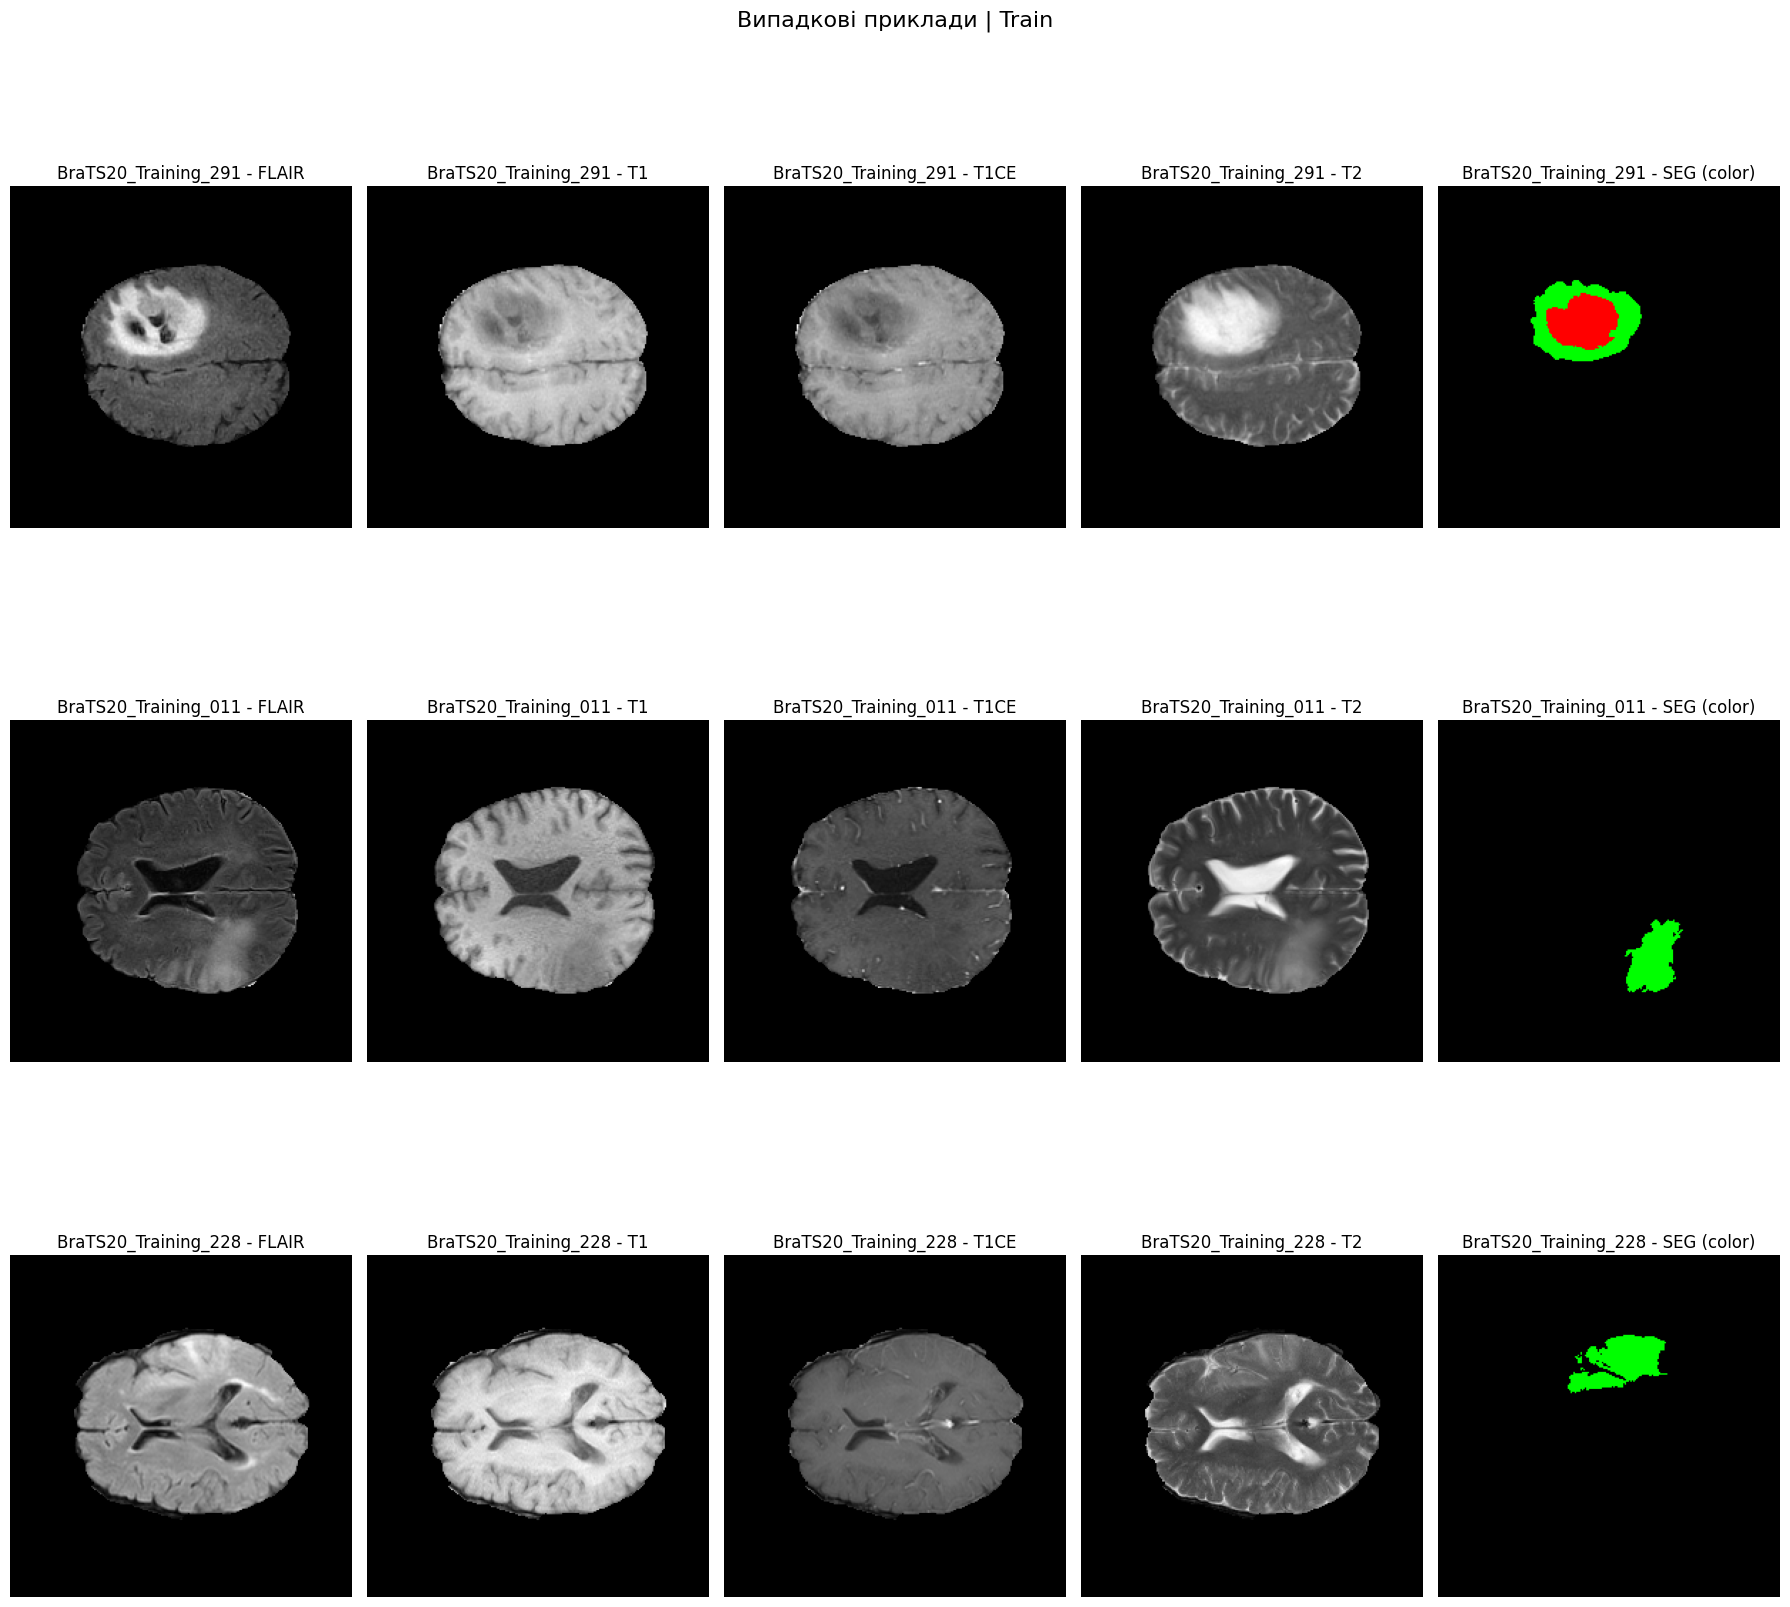

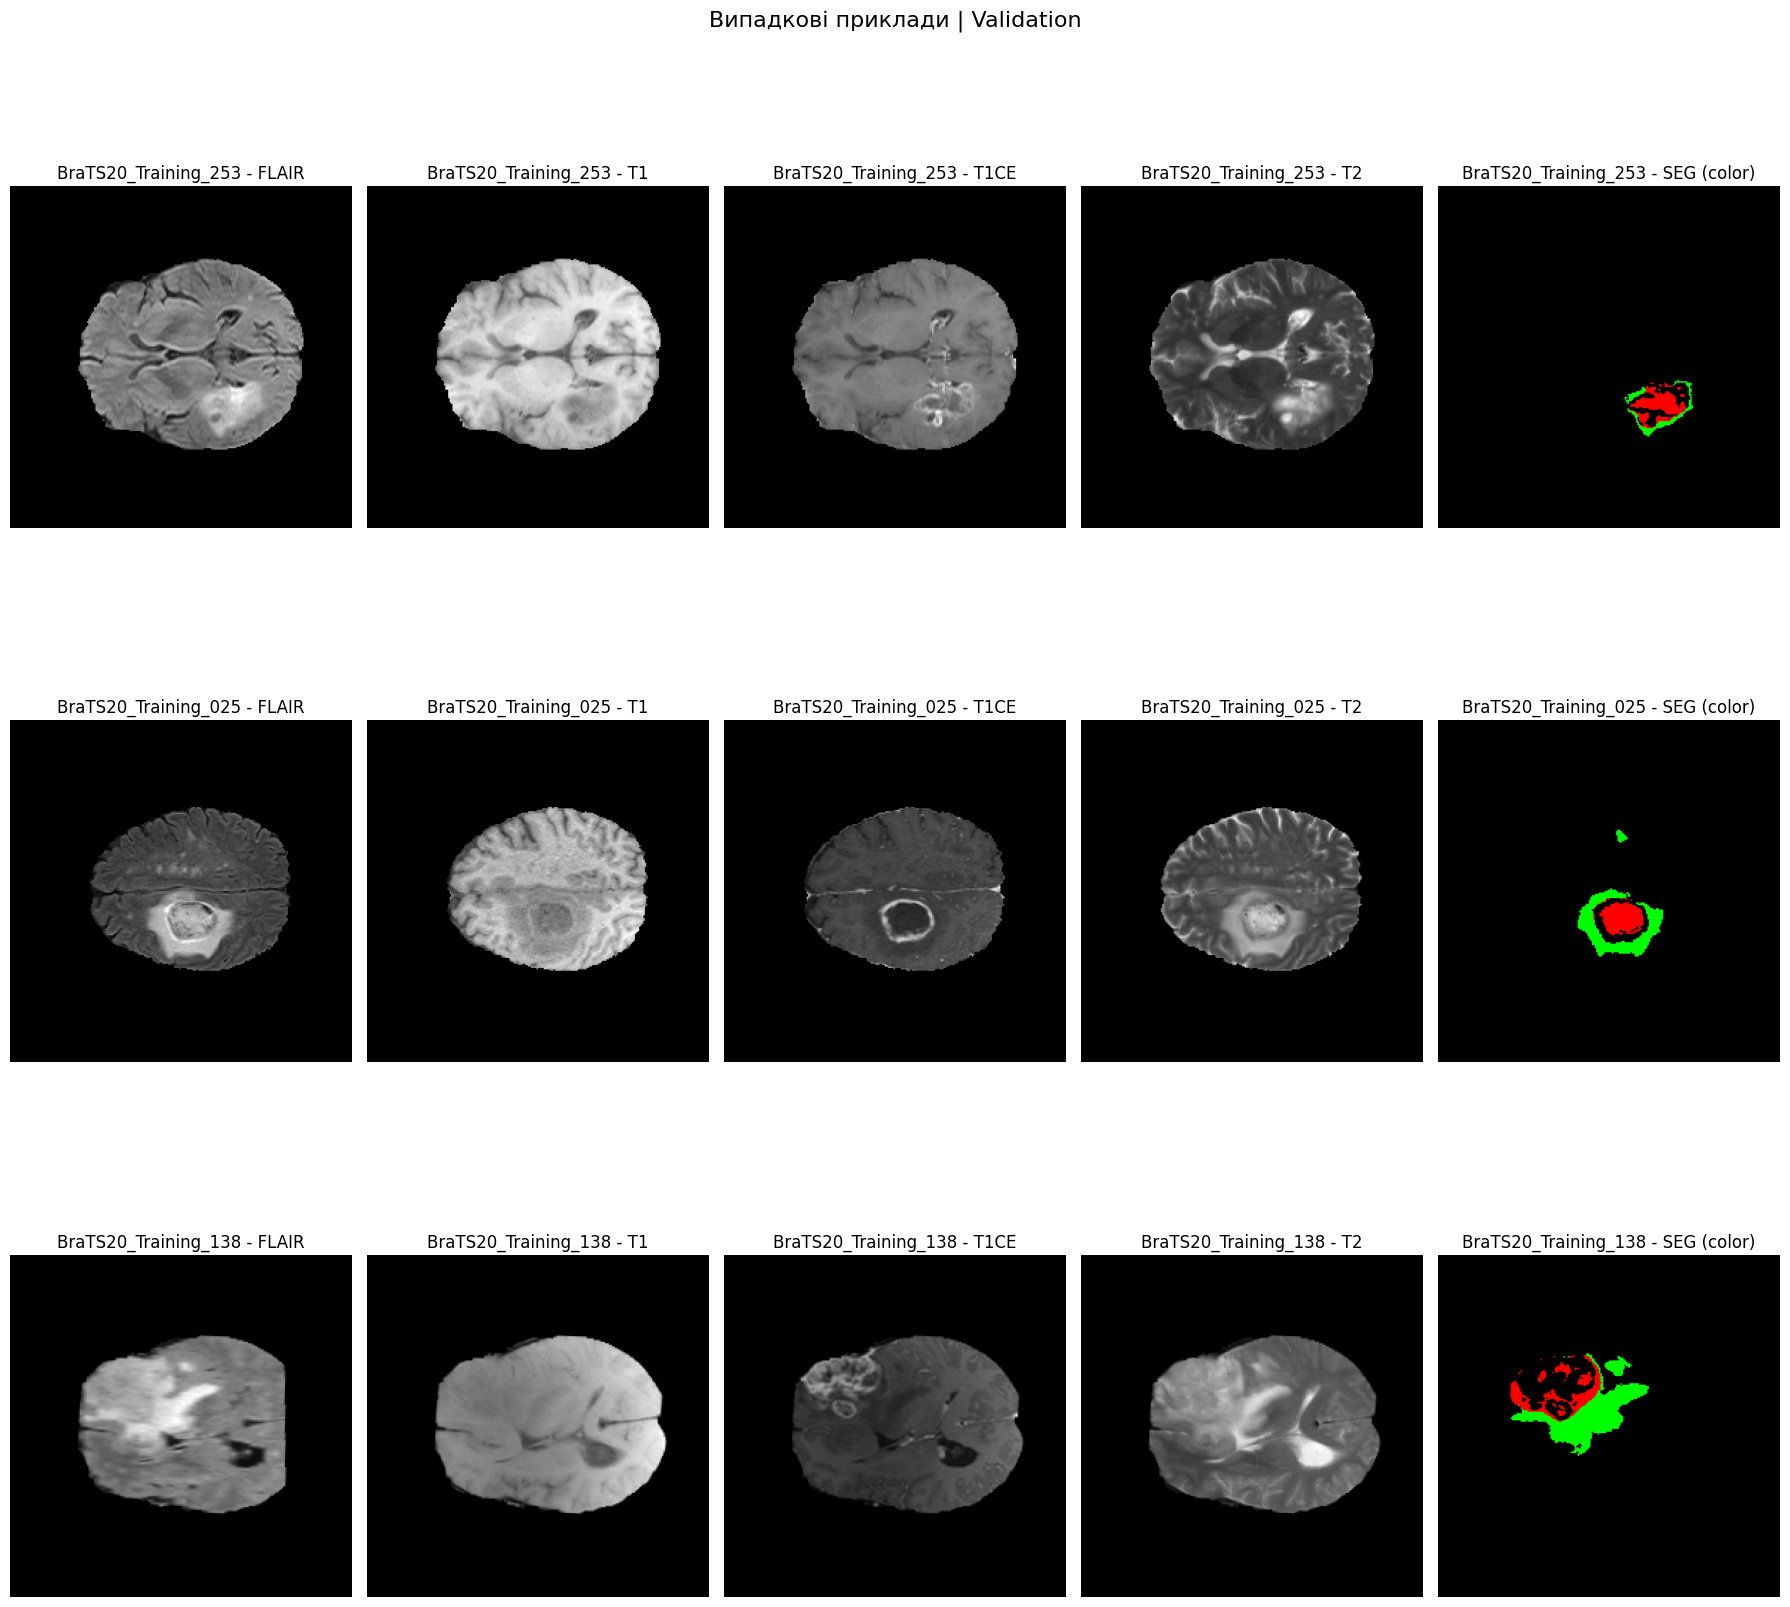

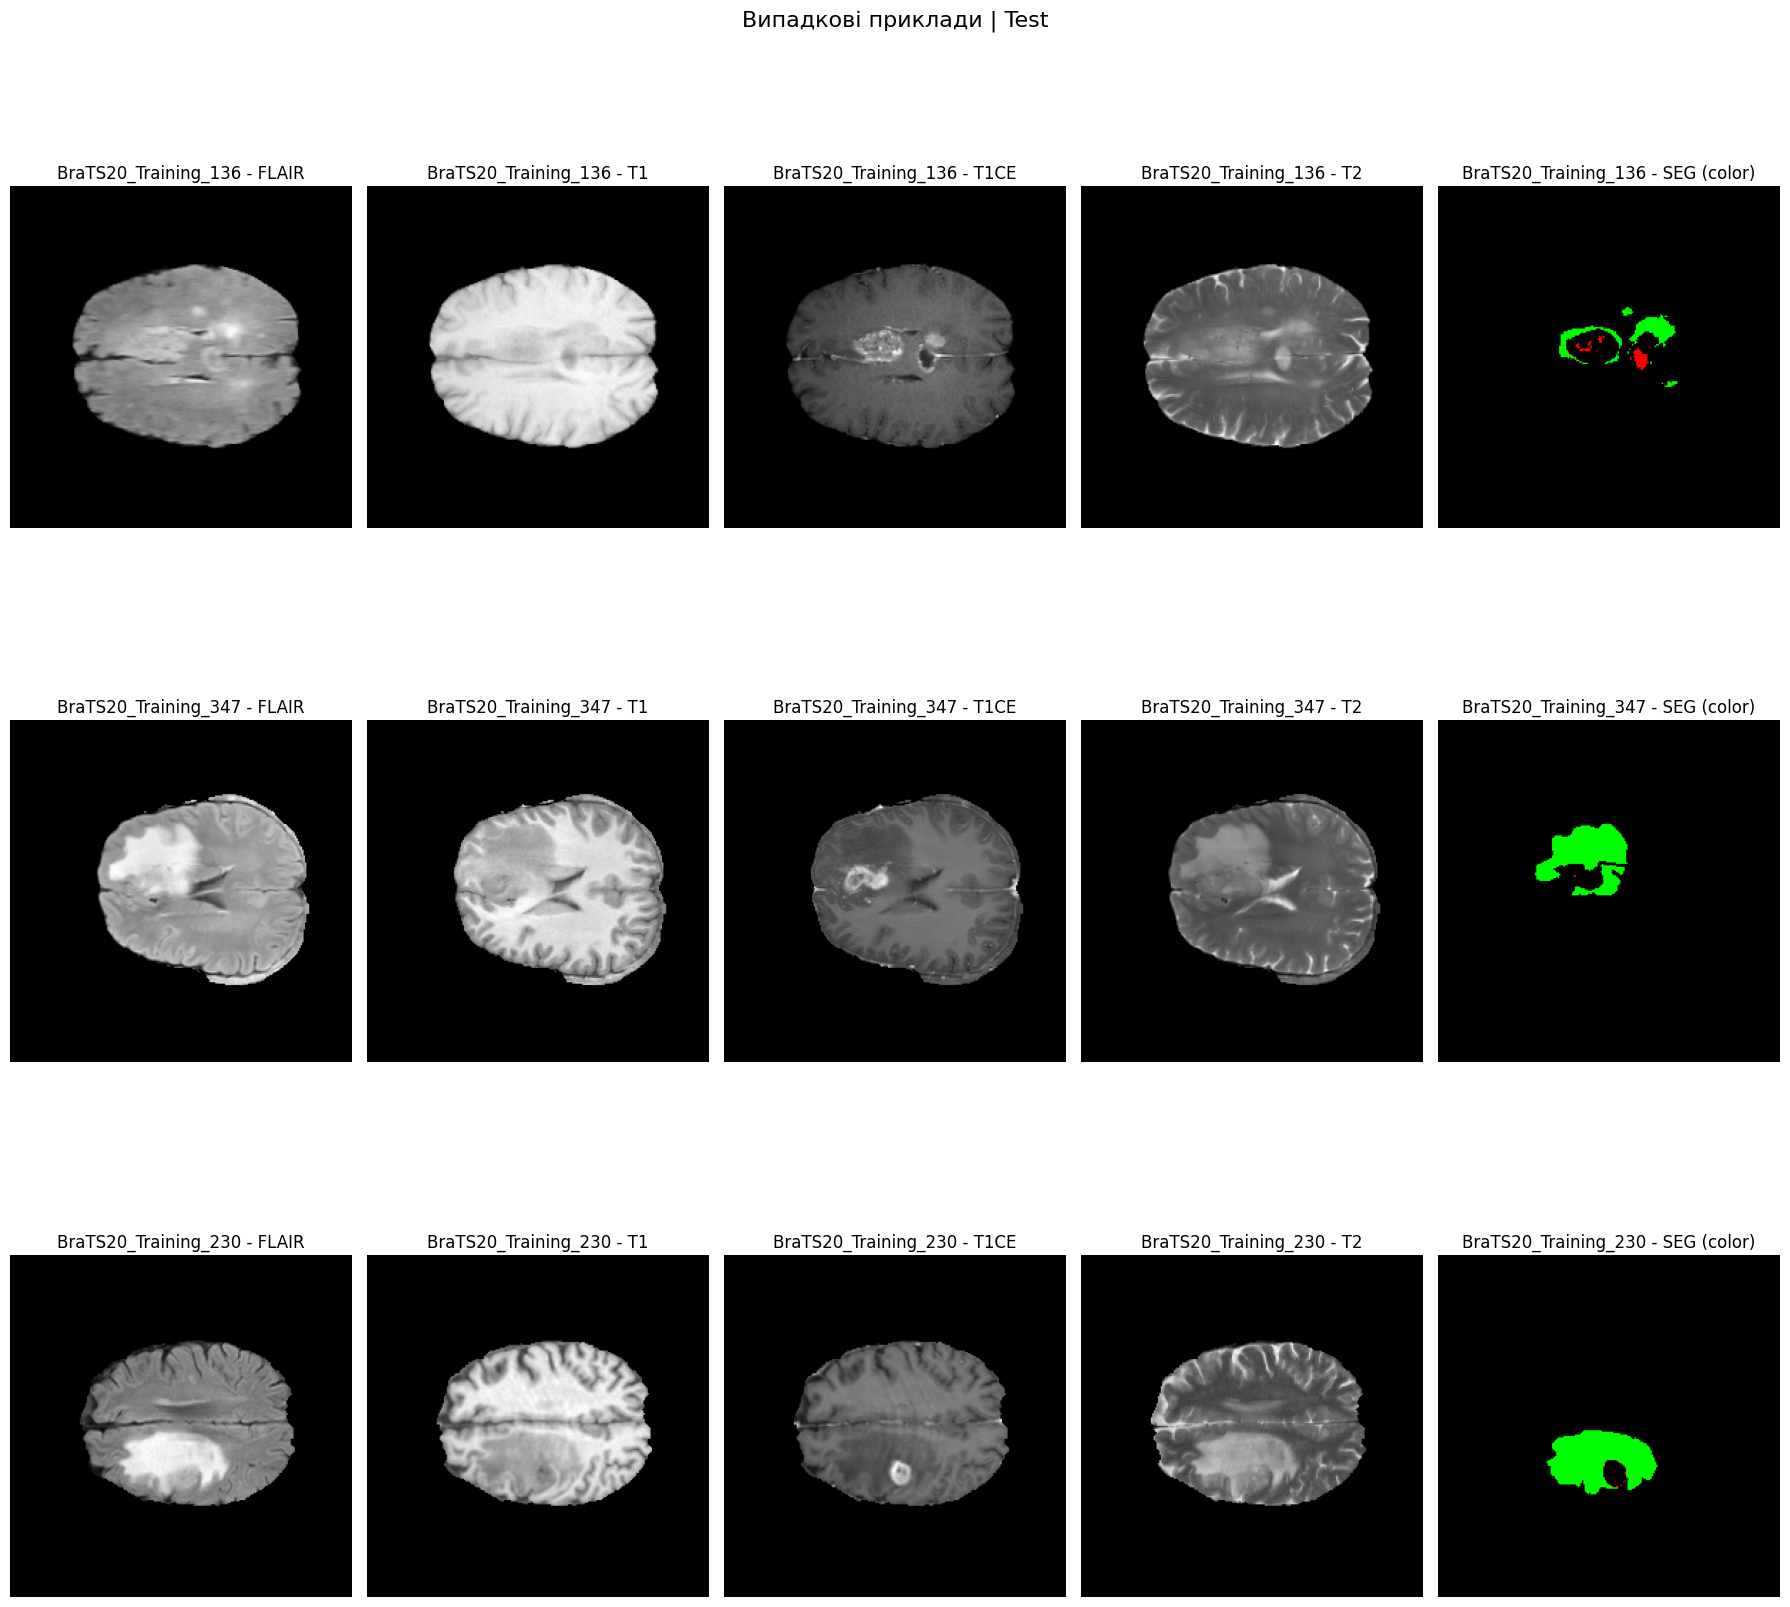

In [ ]:
SEG_COLORS = {
    0: (0, 0, 0),        # Фон – чорний
    1: (255, 0, 0),      # Некроз – червоний
    2: (0, 255, 0),      # Набряк – зелений
    3: (255, 255, 0)     # Активна пухлина – жовтий
}


def label_to_color(seg_slice):
    h, w = seg_slice.shape
    color_img = np.zeros((h, w, 3), dtype=np.uint8)
    for label, color in SEG_COLORS.items():
        color_img[seg_slice == label] = color
    return color_img

def show_random_visuals(patients, data_dir, title="Train", num_cases=3, slice_range=(60, 100)):
    modalities = ["flair", "t1", "t1ce", "t2"]
    selected = random.sample(patients, min(num_cases, len(patients)))

    plt.figure(figsize=(18, 6 * len(selected)))

    for idx, case_id in enumerate(selected):
        case_path = os.path.join(data_dir, case_id)
        images = []

        for mod in modalities:
            img_path = os.path.join(case_path, f"{case_id}_{mod}.nii.gz")
            img = nib.load(img_path).get_fdata()
            images.append(img)

        seg_path = os.path.join(case_path, f"{case_id}_seg.nii.gz")
        seg = nib.load(seg_path).get_fdata().astype(np.uint8)

        slice_idx = random.randint(*slice_range)

        for i, mod_img in enumerate(images):
            plt.subplot(len(selected), 5, idx * 5 + i + 1)
            plt.imshow(mod_img[:, :, slice_idx], cmap='gray')
            plt.title(f"{case_id} - {modalities[i].upper()}")
            plt.axis("off")

        plt.subplot(len(selected), 5, idx * 5 + 5)
        color_mask = label_to_color(seg[:, :, slice_idx])
        plt.imshow(color_mask)
        plt.title(f"{case_id} - SEG (color)")
        plt.axis("off")

    plt.suptitle(f"Випадкові приклади | {title}", fontsize=16)
    plt.tight_layout()
    plt.show()

train_patients = read_patients("train.txt")
val_patients   = read_patients("val.txt")
test_patients  = read_patients("test.txt")
data_dir = "/content/brats20-dataset-training-validation/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData"

show_random_visuals(train_patients, data_dir, title="Train")
show_random_visuals(val_patients, data_dir, title="Validation")
show_random_visuals(test_patients, data_dir, title="Test")

In [ ]:
!pip install torchsummary

In [ ]:
# Якщо модель очікує вхід [B, 4, 240, 240, 40] — тобто 4 канали, 3D том
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Improved3DUNet().to(device)

# Показати структуру
summary(model, input_size=(1, 4, 128, 128, 64))

Layer (type:depth-idx)                   Output Shape              Param #
Improved3DUNet                           [1, 4, 128, 128, 64]      --
├─ResidualBlock: 1-1                     [1, 32, 128, 128, 64]     --
│    └─Conv3d: 2-1                       [1, 32, 128, 128, 64]     160
│    └─Conv3d: 2-2                       [1, 32, 128, 128, 64]     3,488
│    └─BatchNorm3d: 2-3                  [1, 32, 128, 128, 64]     64
│    └─ReLU: 2-4                         [1, 32, 128, 128, 64]     --
│    └─Conv3d: 2-5                       [1, 32, 128, 128, 64]     27,680
│    └─BatchNorm3d: 2-6                  [1, 32, 128, 128, 64]     64
│    └─ReLU: 2-7                         [1, 32, 128, 128, 64]     --
├─MaxPool3d: 1-2                         [1, 32, 64, 64, 32]       --
├─ResidualBlock: 1-3                     [1, 64, 64, 64, 32]       --
│    └─Conv3d: 2-8                       [1, 64, 64, 64, 32]       2,112
│    └─Conv3d: 2-9                       [1, 64, 64, 64, 32]       55,360


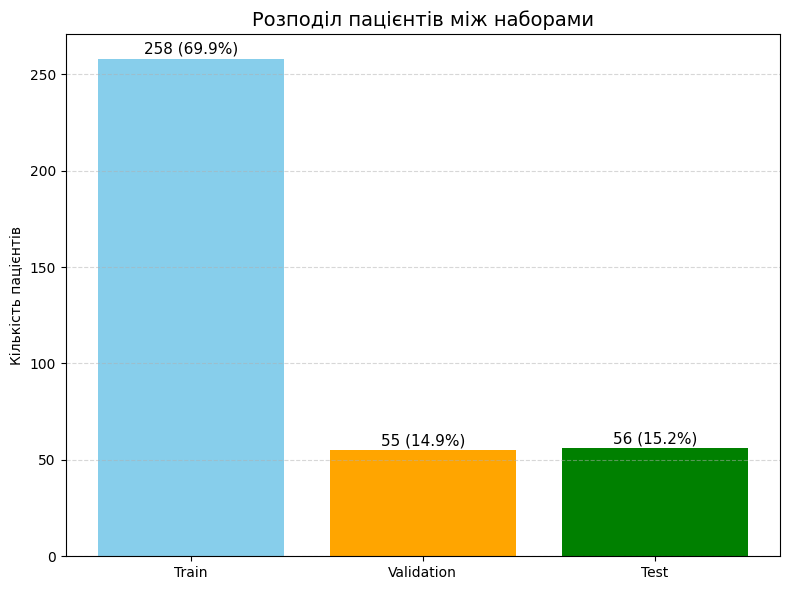

In [ ]:
# Розміри наборів
n_train = len(read_patients("train.txt"))
n_val = len(read_patients("val.txt"))
n_test = len(read_patients("test.txt"))
total = n_train + n_val + n_test

# Дані
counts = [n_train, n_val, n_test]
labels = ['Train', 'Validation', 'Test']
percents = [count / total * 100 for count in counts]

# Побудова гістограми
plt.figure(figsize=(8, 6))
bars = plt.bar(labels, counts, color=['skyblue', 'orange', 'green'])

# Додавання підписів з відсотками
for i, bar in enumerate(bars):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1,
             f"{counts[i]} ({percents[i]:.1f}%)", ha='center', va='bottom', fontsize=11)

plt.title("Розподіл пацієнтів між наборами", fontsize=14)
plt.ylabel("Кількість пацієнтів")
plt.grid(axis='y', linestyle='--', alpha=0.5)

# Збереження
plt.tight_layout()
plt.savefig("/content/dataset_split_histogram_percent.png")
plt.show()


# **############################################################**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def conv_block(x, filters):
    x = layers.Conv3D(filters, 3, padding='same', activation='relu')(x)
    x = layers.Conv3D(filters, 3, padding='same', activation='relu')(x)
    return x

def encoder_block(x, filters):
    c = conv_block(x, filters)
    p = layers.MaxPooling3D(pool_size=(2, 2, 2))(c)
    return c, p

def decoder_block(x, skip, filters):
    up = layers.Conv3DTranspose(filters, kernel_size=2, strides=2, padding='same')(x)
    x = layers.Concatenate()([up, skip])
    x = conv_block(x, filters)
    return x

def build_lightweight_3d_unet(input_shape=(64, 64, 64, 1), num_classes=4, base_filters=8):
    inputs = layers.Input(shape=input_shape)

    # Encoder (скорочено до 2 рівнів)
    s1, p1 = encoder_block(inputs, base_filters)
    s2, p2 = encoder_block(p1, base_filters * 2)

    # Bottleneck
    b = conv_block(p2, base_filters * 4)

    # Decoder
    d1 = decoder_block(b, s2, base_filters * 2)
    d2 = decoder_block(d1, s1, base_filters)

    # Output
    outputs = layers.Conv3D(num_classes, 1, activation='softmax')(d2)

    model = Model(inputs, outputs)
    return model

# Побудова моделі
model = build_lightweight_3d_unet()

# Виведення структури моделі
model.summary()
model.save("3d_unet_model.h5")



Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 64, 64,    │          0 │ -                 │
│ (InputLayer)        │ 64, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d (Conv3D)     │ (None, 64, 64,    │        224 │ input_layer[0][0] │
│                     │ 64, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_1 (Conv3D)   │ (None, 64, 64,    │      1,736 │ conv3d[0][0]      │
│                     │ 64, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d       │ (None, 32, 32,    │          0 │ conv3d_1[0][0]    │
│ (MaxPooling3D)      │ 32, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_2 (Conv3D)   │ (None, 32, 32,    │      3,472 │ max_pooling3d[0]… │
│                     │ 32, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_3 (Conv3D)   │ (None, 32, 32,    │      6,928 │ conv3d_2[0][0]    │
│                     │ 32, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling3d_1     │ (None, 16, 16,    │          0 │ conv3d_3[0][0]    │
│ (MaxPooling3D)      │ 16, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_4 (Conv3D)   │ (None, 16, 16,    │     13,856 │ max_pooling3d_1[… │
│                     │ 16, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_5 (Conv3D)   │ (None, 16, 16,    │     27,680 │ conv3d_4[0][0]    │
│                     │ 16, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_transpose    │ (None, 32, 32,    │      4,112 │ conv3d_5[0][0]    │
│ (Conv3DTranspose)   │ 32, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 32, 32,    │          0 │ conv3d_transpose… │
│ (Concatenate)       │ 32, 32)           │            │ conv3d_3[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_6 (Conv3D)   │ (None, 32, 32,    │     13,840 │ concatenate[0][0] │
│                     │ 32, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_7 (Conv3D)   │ (None, 32, 32,    │      6,928 │ conv3d_6[0][0]    │
│                     │ 32, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_transpose_1  │ (None, 64, 64,    │      1,032 │ conv3d_7[0][0]    │
│ (Conv3DTranspose)   │ 64, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 64, 64,    │          0 │ conv3d_transpose… │
│ (Concatenate)       │ 64, 16)           │            │ conv3d_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_8 (Conv3D)   │ (None, 64, 64,    │      3,464 │ concatenate_1[0]… │
│                     │ 64, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv3d_9 (Conv3D)   │ (None, 64, 64,    │      1,736 │ conv3d_8[0][0]  

 Total params: 85,044 (332.20 KB)

 Trainable params: 85,044 (332.20 KB)

 Non-trainable params: 0 (0.00 B)